In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

### STRATEGY 1: RUN ENTIRE DATA THROUGH LASSO, MODEL WILL DROP ALL UNCESSARY INPUTS

In [2]:
#preprocessing data
#fill NANs with 0, create dummy variables
ames = pd.read_csv('data/ames_housing.csv')
ames = ames.fillna(0)
ames = pd.get_dummies(ames, drop_first=True)

#create train_test_split
X = ames.drop(['SalePrice','Id'], axis = 1)
y = ames['SalePrice']
ames_numeric = X.select_dtypes(include = ['int64','float64'])
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [3]:
#lasso with train test split doesn't run because there are TOO MANY VARIABLES; FAILS TO CONVERGE
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Lasso())
params = {'polynomialfeatures__degree' : [1,2,3]}
grid = GridSearchCV(pipe, param_grid=params, cv=4)
#grid.fit(X_train, y_train)

### STRATEGY 2: ELIMINATE COLUMNS THAT I *THINK* ARE LESS IMPORTANT(NO DOMAIN KNOWLEDGE). WILL RUN THROUGH LASSO ONE MORE TIME AFTER TO DROP ADDITIONAL COLUMNS.

##### Preprocessing data

In [4]:
#extract nessary columns first
ames = pd.read_csv('data/ames_housing.csv') 
ames = ames[['LotArea', 'Street', 'LandSlope','BldgType', 'OverallQual',
             'YearBuilt', 'RoofStyle', 'BsmtQual', 'HeatingQC', 'CentralAir', 
             'GrLivArea', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageQual', 'PoolQC',
             'MiscVal', 'SalePrice']]

#Replacing ordinal variables and filling missing values with 0, since that implies those houses are missing those units
ames = ames.replace({"LandSlope": {'Gtl':3, 'Mod':2, 'Sev':1}, 
                     "BsmtQual" : {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                     "HeatingQC": {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                     "FireplaceQu": {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                     "GarageQual": {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                     "PoolQC": {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}})
ames = ames.fillna(0)


#Creating dummy variables from Street, Neighborhood, BldgType, RoofStyle, CentralAir
ames = pd.get_dummies(ames, drop_first=True)

#Create new column for fun called quality_test (addition of all quality/oridnal columns)
ames['quality_test'] = ames['LandSlope'] + ames['OverallQual'] + ames['BsmtQual'] + ames['HeatingQC'] + ames['FireplaceQu'] + ames['GarageQual'] + ames['PoolQC']

Text(0.5,1,'OverallQual')

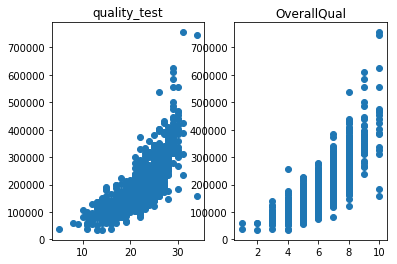

In [5]:
# quick look at outputs to see range and relationship to quality_test, Overall_quality.
plt.subplot(1,2,1)
plt.scatter(ames.quality_test, ames.SalePrice);
plt.title('quality_test')

plt.subplot(1,2,2)
plt.scatter(ames.OverallQual, ames.SalePrice);
plt.title('OverallQual')

In [6]:
#Creating train_test_split and scaling
#DO I HAVE TO TAKE LOG OF OUTPUTS?!?!??!?!?!
X = ames.drop('SalePrice', axis = 1)
y = ames.SalePrice

def scale_data(x,y):
    std_scaled = StandardScaler()
    scaled_x = std_scaled.fit_transform(x)
    return scaled_x, y

X_train, X_test, y_train, y_test = train_test_split(X,y)

X_train, y_train = scale_data(X_train, y_train)
X_test, y_test = scale_data(X_test, y_test)

##### Lasso Regression with grid search for alpha to drop insignificant columns

In [7]:
#pipeline standard scaler, lasso (grid search optimal alpha)
pipe = make_pipeline(StandardScaler(), Lasso(tol=0.1))
params = {'lasso__alpha' : [0.1, 0.5, 1, 1.5]}
grid = GridSearchCV(pipe, param_grid=params, cv=5)
grid.fit(X_train, y_train);

#HOW DO YOU GET COEFFICIENTS AND NAMES OF COLUMNS FROM GRID SEARCH???!??!

In [8]:
#get name of columns that are 'important'
lasso_reg = Lasso(alpha=1.0, tol=1)
lasso_reg.fit(X_train, y_train)
for e in sorted (list(zip(list(X), lasso_reg.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))

        
#looks like everything has a significant coefficient. I did a good job feature selecting.

	OverallQual, 52335.237
	GrLivArea, 17093.997
	LotArea, 12693.203
	YearBuilt, 11985.017
	quality_test, -10021.076
	BldgType_TwnhsE, -6434.623
	BsmtQual, 6079.313
	BldgType_Twnhs, -5383.186
	RoofStyle_Gable, -4638.646
	FireplaceQu, 3778.476
	Street_Pave, 3501.916
	CentralAir_Y, -3009.230
	LandSlope, -2655.804
	HeatingQC, 2357.020
	TotRmsAbvGrd, 1395.736
	MiscVal, -759.893
	RoofStyle_Hip, 758.800
	PoolQC, -653.219
	GarageQual, -494.028
	BldgType_2fmCon, 388.994
	RoofStyle_Shed, -383.811
	RoofStyle_Gambrel, -372.879
	RoofStyle_Mansard, -332.860
	BldgType_Duplex, 294.776


##### Linear, Ridge, Lasso, Elastic Net with polynoial Features to find best model

In [9]:
#Function. Takes in model and parameter and returns best hyperparameter, r^2 and RMSE
def linear_model_with_hyper_params(model, params):
    pipe = make_pipeline(PolynomialFeatures(), model)
    grid = GridSearchCV(pipe, param_grid=params, cv=3)
    grid.fit(X_train, y_train)
    best_params = str(grid.best_params_)
    best = grid.best_estimator_
    pred = best.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    score = best.score(X_test, y_test)
    print('Best Params are {}'.format(best_params), 
          '\nThe r2 value is : {:.4f}'.format(score), 
          '\nThe RMSE value is {:.4f}'.format(rmse))

In [10]:
# Linear 
params = {'polynomialfeatures__degree' : [1, 2, 3]}
linear_model_with_hyper_params(LinearRegression(), params)

Best Params are {'polynomialfeatures__degree': 1} 
The r2 value is : 0.7620 
The RMSE value is 40134.9782


In [11]:
# Lasso
params = {'ridge__alpha' : [0.1, 1, 5, 10], 'polynomialfeatures__degree' : [1, 2, 3]}
linear_model_with_hyper_params(Ridge(), params)

Best Params are {'polynomialfeatures__degree': 1, 'ridge__alpha': 10} 
The r2 value is : 0.7617 
The RMSE value is 40154.9122


In [12]:
#Ridge
params = {'lasso__alpha' : [0.1, 1, 5, 10], 'polynomialfeatures__degree' : [1, 2, 3]}
linear_model_with_hyper_params(Lasso(tol=1), params)

Best Params are {'lasso__alpha': 10, 'polynomialfeatures__degree': 1} 
The r2 value is : 0.7329 
The RMSE value is 42518.9939


In [13]:
#Elastic Net: HOW DO YOU PASS L1_Ratio AS HYPER PARAMETER???!?!?!?!
params = {'elasticnet__alpha' : [0.1, 1, 5, 10], 'polynomialfeatures__degree' : [1, 2, 3]}
linear_model_with_hyper_params(ElasticNet(tol=1), params)

Best Params are {'elasticnet__alpha': 1, 'polynomialfeatures__degree': 1} 
The r2 value is : 0.7565 
The RMSE value is 40594.4771


## CONCLUSION: Linear Regression seems to fit data the best. Will need to do a better job creating new features or doing better feature selection to improve RMSE and r-squared